# Data preprocessing

In [1]:
import pickle
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
#%matplotlib inline
import cv2

# For one hot encoding
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def save_to_pickle(path = None, name = None, data = None):
    with open(path+name, "wb") as f:
        print("\t => Save '{0}' to '{1}'".format(name, path))
        pickle.dump(data, f)

In [2]:
# Seperate data and labels, and reshape data to python readable RGB channels
def preprocess_cifar10_data(cifar):
    data = cifar[b'data']
    labels = cifar[b'labels']
    
    # # Change channel of image to the last dimension
    data = np.reshape(data, (-1, 3, 32, 32))
    data = np.moveaxis(data, 1, 3)
    
    return data, labels

In [3]:
label_name = {0:"airplane", 1:"automobile", 2:"bird", 3:"cat", 
              4:"deer", 5:"dog", 6:"frog", 7:"horse", 8:"ship", 9:"truck"}

### Test code

In [4]:
cifar_name = "../../../Data/Objects/cifar/cifar-10-batches-py/data_batch_"

test = unpickle(cifar_name+'3')

In [5]:
test.keys()

dict_keys([b'batch_label', b'labels', b'filenames', b'data'])

In [6]:
np.shape(test[b'data'])

(10000, 3072)

In [7]:
data, labels = preprocess_cifar10_data(test)

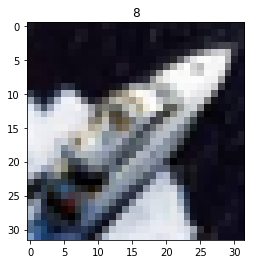

In [8]:
plt.imshow(data[0])
plt.title(labels[0])
plt.show()

### Cifar dataset preprocessing: Merge data

In [9]:
# Load the dataset on computer's volatile memory
features, labels = preprocess_cifar10_data(unpickle(cifar_name+str(1)))

for i in range(2,6):
    feature, label = preprocess_cifar10_data(unpickle(cifar_name+str(i)))
    
    features = np.vstack([features, feature])
    labels = np.hstack([labels, label])
'''
for i in range(1, 6):
    globals()["batch_data_{0}".format(i)], \
    globals()["batch_labels_{0}".format(i)] = \
    preprocess_cifar10_data(unpickle(cifar_name+str(i)))
'''

'\nfor i in range(1, 6):\n    globals()["batch_data_{0}".format(i)],     globals()["batch_labels_{0}".format(i)] =     preprocess_cifar10_data(unpickle(cifar_name+str(i)))\n'

In [10]:
print("Input data shape: ", features.shape)
print("Labels shape: ", labels.shape)

Input data shape:  (50000, 32, 32, 3)
Labels shape:  (50000,)


### Cifar dataset preprocessing: Normalization

In [11]:
def scailing(img, new_min = 0, new_max = 1):
    new_img = img.copy()
    new_img = cv2.normalize(new_img, dst=None, alpha=new_min, beta=new_max, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

    return new_img

# # Normalization for object images
def normalization(dataset):
    new_features = []
    
    for f in tqdm(features):
        #f_gray = self.bgr2gray(f)
        #f_norm = scailing(f, new_min=0, new_max=1)
        #print("feature1 < min: {0} | max: {1} >".format(np.min(f_norm), np.max(f_norm)))
        new_features.append(scailing(f, new_min=0, new_max=1))
        
    return np.array(new_features)
    
#labels = labels.reshape(-1, 1)
features = normalization(features)
#labels = labels.reshape(-1, 1)

100%|██████████| 50000/50000 [00:00<00:00, 90449.10it/s]


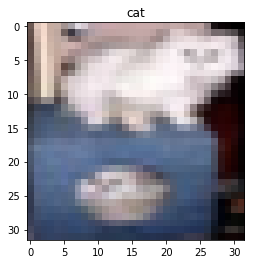

Check the value if nomalized well:  0.98823535


In [12]:
idx = 38
plt.imshow(features[idx])
#plt.title(label_name[labels[idx][0]])
plt.title(label_name[labels[idx]])
plt.show()
print("Check the value if nomalized well: ", np.max(features[idx][:, :, 1]))

### Cifar dataset preprocessing: Onthot encoding

In [13]:
import tensorflow as tf
tf.one_hot(labels, labels.max()+1, axis=1)

with tf.Session() as sess:
    #sess.run(tf.global_variables_initializer())
    labels = sess.run(tf.one_hot(labels, labels.max()+1, axis=1))

print("Onehot labels shape: ", labels.shape)

Onehot labels shape:  (50000, 10)


### Cifar dataset preprocessing: Train set and Test set

In [14]:
from sklearn.model_selection import train_test_split

features_train, features_test, labels_train, labels_test = train_test_split(
    features, labels, test_size=0.33, random_state=42)

print("(train shape) features: {0}, labels: {1}".format(features_train.shape, labels_train.shape))
print("(test shape) features: {0}, labels: {1}".format(features_test.shape, labels_test.shape))

(train shape) features: (33500, 32, 32, 3), labels: (33500, 10)
(test shape) features: (16500, 32, 32, 3), labels: (16500, 10)


# Resnet model

In [ ]:
import tensorflow as tf

class netParam(object):
    def __init__(self, epoch = 5000, batch_size = 1000, learning_rate = 0.001):
        # Input nodes
        self.in_feature_shape = 32
        self.in_feature_channels = 3
        
        self._input_nd = tf.placeholder(
            tf.float32, shape=[None, self.in_feature_shape, self.in_feature_shape, self.in_feature_channels], name="input")
        self._labels_nd = tf.placeholder(tf.int32, shape=[None, 10], name="labels")
        
        '''
        # Layer nodes
        self._logits_nd = None
        self._loss_nd = None
        self._train_optimizer_nd = None
        self._pred_nd = None
        self._acc_nd = None
        '''
        
        # Hyper parameters
        self.kernel_1x1 = 1
        self.kernel_2x2 = 2
        self.kernel_3x3 = 3
        
        self.depth_64 = 64
        self.depth_128 = 128
        self.layer_3_depth = 48
        self.layer_4_depth = 96
        self.layer_5_depth = 192

        self.dense_4096 = 4096
        self.dense_1000 = 1000
        self.dense_output = 2

        self.stride_1x1 = 1
        self.stride_2x2 = 2
        
        # Training parameters
        self._epoch = epoch
        self._batch_size = batch_size
        self._rl = learning_rate
        
    def _filter_var(cls, kernel, in_depth, out_depth, node_name):
        return tf.Variable(
            tf.truncated_normal((kernel, kernel, in_depth, out_depth), stddev=0.1, dtype=tf.float32),
            name=node_name+"_filter")
    
    def _bias_var(cls, size, node_name):
        return tf.Variable(
            tf.zeros([size], dtype=tf.float32), 
            name=node_name+"_bias")

    def _dense_var(cls, in_size, out_size, node_name):
        return tf.Variable(
            tf.truncated_normal([in_size, out_size], stddev=0.1, dtype=tf.float32),
            name=node_name+"_dense")
    
    def _max_pool(cls, in_node, kernel_size, stride_size, pad_type, node_name):
        return tf.nn.max_pool(in_node, 
                              ksize=[1, kernel_size, kernel_size, 1], 
                              strides=[1, stride_size, stride_size, 1], 
                              padding=pad_type,
                              name=node_name+"/Max_pool")
    
    def _avg_pool(cls, in_node, kernel_size, stride_size, pad_type, node_name):
        return tf.nn.avg_pool(in_node, 
                              ksize=[1, kernel_size, kernel_size, 1], 
                              strides=[1, stride_size, stride_size, 1], 
                              padding=pad_type,
                              name=node_name+"/Avg_pool")
    
    def _convolutional_layer(self, in_node, kernel_size, out_depth, stride, padding, name, use_bias=False):
        with tf.variable_scope(name):
            # Weight to be learned
            conv_filter = self._filter_var(
                kernel = kernel_size,
                in_depth=in_node.get_shape().as_list()[-1],
                out_depth=out_depth,
                node_name=name)
            
            # Convolutional node
            conv = tf.nn.conv2d(in_node, conv_filter, [1, stride, stride, 1], padding=padding)
            
            # Biase to be learned
            if use_bias:
                conv_bias = self._bias_var(size=out_depth, node_name=name)
                conv = tf.nn.bias_add(conv, conv_bias)
            
            #conv = tf.nn.relu(conv)

            return conv

    def _dense_layer(self, in_node, dense_size, relu, name):
        #print(in_node.get_shape().as_list())
        dense_weight = self._dense_var(in_size=in_node.get_shape().as_list()[-1], out_size=dense_size, node_name=name)
        dense_bias = self._bias_var(size=dense_size, node_name=name)

        if relu == "relu":
            return tf.nn.relu(tf.add(tf.matmul(in_node, dense_weight), dense_bias))
        else:
            return tf.add(tf.matmul(in_node, dense_weight), dense_bias)

In [ ]:
class Resnet(netParam):
    def __init__(self, epoch = 5000, batch_size = 1000, learning_rate = 0.001):
        super(Resnet, self).__init__(epoch, batch_size, learning_rate)

    def identity_function(self, input_node, filter_depth, identity_name, half=False):
        with tf.variable_scope(identity_name):
            if half:
                input_node = self._convolutional_layer(input_node, self.kernel_3x3, filter_depth, self.stride_2x2, "SAME", "conv_in", False)
                #print(input_node)
            conv1 = self._convolutional_layer(input_node, self.kernel_3x3, filter_depth, self.stride_1x1, "SAME", "conv1", False)
            #print(conv1)
            relu = tf.nn.relu(conv1)
            #print(relu)
            conv2 = self._convolutional_layer(relu, self.kernel_3x3, filter_depth, self.stride_1x1, "SAME", "conv2", False)
            #print(conv2)
            
            #conv2 = tf.multiply(conv2, 0.1)
            conv2 = tf.multiply(conv2, 0.01)
            skip = tf.add(input_node, conv2, name="skip")
            #skip = tf.multiply(input_node, conv2, name="skip")
            relu = tf.nn.relu(skip)
            
            return relu
    def simple_CNN(self, input_node):
        # CONVOLUTIONAL 1
        conv1 = self._convolutional_layer(input_node, 3, 32, 1, "VALID", "conv1")
        
        # FLATTEN
        relu1_shape = conv1.get_shape().as_list()
        conv1_flat = tf.reshape(conv1, [-1, relu1_shape[1]*relu1_shape[2]*relu1_shape[3]])
        
        # DENSE 1
        dense1 = self._dense_layer(conv1_flat, 128, "relu", "dense1")

        # DENSE 2
        dense2 = self._dense_layer(dense1, 10, "None", "dense2")
        
        return dense2
        
    def resnet(self, input_node):
        print("|============================== MODEL INFO. ====================================|")
        print("  Input  : ", input_node)
        # Convolutional layer 1: conv-> relu -> max_pool
        #with tf.variable_scope("layer_1"):
        layer_1 = self._convolutional_layer(input_node, self.kernel_3x3, self.depth_64, self.stride_1x1, "SAME", "layer_1", False)
        #print("  Layer 1: ", layer_1)
        layer_1 = tf.nn.relu(layer_1, name="layer_1/Relu")
        #print("  Layer 1: ", layer_1)
        layer_1 = self._max_pool(layer_1, self.kernel_2x2, self.stride_2x2, "VALID", "layer_1")
        print("  Layer 1: ", layer_1)
        
        layer_2 = self.identity_function(layer_1, 64, "layer_2")
        print("  Layer 2: ", layer_2)
        
        layer_3 = self.identity_function(layer_2, 64, "layer_3")
        print("  Layer 3: ", layer_3)
        
        layer_4 = self.identity_function(layer_3, 64, "layer_4")
        print("  Layer 4: ", layer_4)
        
        layer_5 = self.identity_function(layer_4, self.depth_128, "layer_5", True)
        print("  Layer 5: ", layer_5)
        
        layer_6 = self.identity_function(layer_5, self.depth_128, "layer_6")
        print("  Layer 6: ", layer_6)
        
        layer_7 = self.identity_function(layer_5, self.depth_128, "layer_7")
        print("  Layer 7: ", layer_7)
        
        layer_8 = self.identity_function(layer_5, self.depth_128, "layer_8")
        print("  Layer 8: ", layer_8)
        
        layer_8_avg_pool = self._avg_pool(layer_8, self.kernel_2x2, self.stride_2x2, "VALID", "layer_8")
        print("  Layer 8: ", layer_8_avg_pool)
        
        layer_8_pool_shape = layer_8_avg_pool.get_shape().as_list()
        layer_8_flat = tf.reshape(layer_8_avg_pool, [-1, layer_8_pool_shape[1]*layer_8_pool_shape[2]*layer_8_pool_shape[3]])
        print("  Layer 8: ", layer_8_flat)
        
        #layer_8_flat_shape = layer_8_flat.get_shape().as_list()
        logits = self._dense_layer(layer_8_flat, 10, "None", name="logits")
        print("  Logits : ", logits)
        print("|===============================================================================|")
        
        return logits

    def _cost_function(self, logits):
        # CONST FUNCTION
        #loss_nd = tf.losses.sparse_softmax_cross_entropy(labels=self._labels_nd, logits=logits)
        print("KKK: ", logits)
        loss_nd = tf.nn.softmax_cross_entropy_with_logits(labels=self._labels_nd, logits=logits)
        return loss_nd

    def _optimizer(self, loss):
        # OPTIMIZER
        optimizer = tf.train.AdamOptimizer(learning_rate=self._rl)
        train_op = optimizer.minimize(loss, global_step=tf.train.get_global_step())
        return train_op

    def _prediction(self, logits):
        # PREDICTION
        pred = tf.argmax(logits, 1)
        return pred

    def _accuracy(self, pred):
        # ACCURACY
        acc = tf.equal(pred, tf.argmax(self._labels_nd, 1))
        return acc
        
    def _accuracy_info(self, iterator, session, accuracy_node, batch_x, batch_y, test_x, test_y):
        train_acc = session.run(accuracy_node, feed_dict={self._input_nd: batch_x, self._labels_nd: batch_y})
        
        batch_index = np.random.choice(len(test_x), size=self._batch_size)
        test_batch_x = test_x[batch_index]
        test_batch_y = test_y[batch_index]
        
        eval_acc = session.run(accuracy_node, feed_dict={self._input_nd: test_batch_x, self._labels_nd: test_batch_y})

        #print("({0}/{1}) TRAIN ACC.: {2} %"\
        #      .format(iter, self._epoch, np.sum(train_acc)/len(train_acc)*100))

        print("({0}/{1}) TRAIN ACC.: {2} % | EVAL ACC.: {3} %"\
              .format(iterator, self._epoch, np.sum(train_acc)/len(train_acc)*100, np.sum(eval_acc)/len(eval_acc)*100))
        
    def train(self):
        logits = self.resnet(self._input_nd)
        #logits = self.simple_CNN(self._input_nd)
        loss = self._cost_function(logits)
        optimizer = self._optimizer(loss)
        pred = self._prediction(logits)
        acc = self._accuracy(pred)
        
        #fig, ax = plt.subplots(1, 4, figsize=(10, 5))

        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())

            for iterator in range(self._epoch):
                batch_index = np.random.choice(len(features_train), size=self._batch_size)
                #self.batch_x = features[batch_index]
                #self.batch_y = labels[batch_index]

                batch_x = features_train[batch_index]
                batch_y = labels_train[batch_index]

                '''
                a = sess.run(logits, feed_dict={self._input_nd: batch_x, self._labels_nd: batch_y})
                print(np.shape(a))
                '''
                sess.run(optimizer, feed_dict={self._input_nd: batch_x, self._labels_nd: batch_y})

                if iterator % 50 == 0:
                    self._accuracy_info(iterator, sess, acc, batch_x, batch_y, features_test, labels_test)
                    
                    pred_labels = sess.run(pred, feed_dict={self._input_nd: features_test[:self._batch_size]})
                    print("\t", np.argmax(labels_test[:self._batch_size][:10], axis=1))
                    print("\t", pred_labels[:10], "\n")
                    #print(np.sum(pred_labels != 0))
                
                '''
                for i in range(4):
                    ax[i].imshow(features_test[:self._batch_size][i])
                    ax[i].set_title(pred_labels[i])

                plt.pause(0.001)
                plt.show()
                '''

In [ ]:
rn = Resnet(epoch = 1000, batch_size = 1000, learning_rate = 0.001)
rn.train()